______
# CURVED NETWORK EDGES
 use environment : edgebundling
______

In [1]:
# env: bez_env (python 3.8.2)

In [2]:
inputpath = 'input/'

# BEZIER CURVES

In [3]:
import bezier

In [4]:
# work around since env using python 3.8.x instead of 3.9.x ... 
import importlib.resources as importlib_res
import importlib_resources
setattr(importlib_res, "files", importlib_resources.files)
setattr(importlib_res, "as_file", importlib_resources.as_file)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from fa2 import ForceAtlas2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import itertools
import math 
import geopandas as gpd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon

In [7]:
#!pip install pycountry
import pycountry

In [8]:
##################################################################################
#
# CODE FROM : https://github.com/beyondbeneath/bezier-curved-edges-networkx
#
##################################################################################

def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == 'random':
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l)==0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(np.mod(np.vectorize(hash)(edges[:,0])+np.vectorize(hash)(edges[:,1]),2)==0,-1,1)
    
    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse = True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1 = coords[:,0,:]
    coords_node2 = coords[:,1,:]
    
    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:,0] > coords_node2[:,0]
    coords_node1[should_swap], coords_node2[should_swap] = coords_node2[should_swap], coords_node1[should_swap]
    
    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1-coords_node2)**2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])
    m2 = -1/m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist/np.sqrt(1+m1**2)
    v1 = np.array([np.ones(l),m1])
    coords_node1_displace = coords_node1 + (v1*t1).T
    coords_node2_displace = coords_node2 - (v1*t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist/np.sqrt(1+m2**2)
    v2 = np.array([np.ones(len(edges)),m2])
    coords_node1_ctrl = coords_node1_displace + (rnd*v2*t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd*v2*t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array([coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2])

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:,i,:].T
        curveplots.append(bezier.Curve(nodes, degree=2).evaluate_multi(np.linspace(0,1,bezier_precision)).T)
      
    # Return an array of these curves
    curves = np.array(curveplots)
    return curves

# Data :
### https://vis.csh.ac.at/vis-workshop-2024/workpackage/supplychain_data/supplychain_data.zip

In [9]:
import pandas as pd

# Load the datasets
nodes_df = pd.read_csv('supplychain_data/nodes.csv')
links_2023_df = pd.read_csv('supplychain_data/links_2023.csv')
links_2013_df = pd.read_csv('supplychain_data/links_2013.csv')

# Add a column to indicate the year for each link
links_2013_df['year'] = 2013
links_2023_df['year'] = 2023

In [10]:
nodes_df

,ascii_id_company,name_internat,name_native,postcode,city,city_native,country,country_iso_code,website_address,operating_revenue_turnover,number_of_employees
0,+/7B81WwUmW1o3jUMStX5w==,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,CN,qlled.com,298703260.0,360.0
1,+/9MLVq3VTixfe87LXPeeA==,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,ES,www.p4q.com,51788833.0,184.0
2,+0MnLjmcWAWGCbG24We7Yw==,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,DE,www.multitest.com,128040853.0,360.0
3,+1zmH6cnV8mWu/xN4Abihw==,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,US,www.wonikquartz.com,3800000.0,100.0
4,+4aKZ6LdUyOpKvOnV7veEA==,Toko Electronic Manufacturing Company Limited,東光電子製造廠有限公司,NaN,Kwun Tong,Kwun Tong,"Hong Kong SAR, China",HK,www.toko.com.hk,180000000.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...
2974,zraU0EFmWYW/tBv24D5yKQ==,Lantiq Deutschland GmbH,Lantiq Deutschland GmbH,85579,Neubiberg,Neubiberg,Germany,DE,www.lantiq.com,459812111.0,359.0
2975,zuyBw2vWW3CWiUgVE5nauw==,"Beijing opto-electronics technology co., ltd.",北京雷生强式科技有限责任公司,100015,Beijing,北京市,China,CN,www.oet.com.cn,12330740.0,NaN
2976,zxMabQ1WX6SMB9JnYHe6kQ==,Desert Silicon LLC,Desert Silicon LLC,85305-2501,Glendale,Glendale,United States of America,US,www.desertsilicon.com,510000.0,10.0
2977,zyStouZPVu6POVRd2Juqtw==,"Wacco Co.,Ltd",(주)와코,34036,Daejeon,Daejeon,Republic of Korea,KR,www.wacco.co.kr,27324644.0,25.0


In [11]:
# remove NaN
nodes_df = nodes_df.dropna()
links_2013_df = links_2013_df.dropna()
links_2023_df = links_2023_df.dropna()

In [12]:
links_2013_df

,src_id,dst_id,count,year
0,+CY58D3RXbaPGtbNczkwkA==,0yd99stpXMW98ycgIDk9Mg==,53.0,2013
1,+CY58D3RXbaPGtbNczkwkA==,1SPLf5bUUHGLwuTcWsh00Q==,20.0,2013
2,+CY58D3RXbaPGtbNczkwkA==,1fqkJPEgWNSBSjshlZZ4Wg==,15.0,2013
3,+CY58D3RXbaPGtbNczkwkA==,3ZjoxOm+X8KGpWJD66yXWg==,79257.0,2013
4,+CY58D3RXbaPGtbNczkwkA==,8/onIJz0VGSOnlTBcomH/A==,41.0,2013
...,...,...,...,...
757,zzY/xgpdXhm3ORHIkr25UA==,Srdkce9RXdWwCAWrKNDb7g==,38.0,2013
758,zzY/xgpdXhm3ORHIkr25UA==,WgRbG5RqWL2juqgk0+P03g==,133.0,2013
759,zzY/xgpdXhm3ORHIkr25UA==,cUcvHVnSWPSc+cvpmNP5IQ==,6.0,2013
760,zzY/xgpdXhm3ORHIkr25UA==,dy42m4aTVpqLpCFkUR4SzA==,4.0,2013


In [13]:
links_2023_df

,src_id,dst_id,count,year
0,+/7B81WwUmW1o3jUMStX5w==,BxlB6zCnVA6XXHcDqSfkJg==,40,2023
1,+Bfo8czAWCm3yspyAhPwtg==,6tcYm0Y0U+SqZDgb3DSn0A==,1,2023
2,+CY58D3RXbaPGtbNczkwkA==,/t/Orqw3XWm0ZCcR/wTqTg==,1,2023
3,+CY58D3RXbaPGtbNczkwkA==,0Oovy9pzUTq8GcHgAlc4lQ==,16,2023
4,+CY58D3RXbaPGtbNczkwkA==,0nBNEZJVXHeGfsQn5m1O7Q==,2,2023
...,...,...,...,...
3885,zzY/xgpdXhm3ORHIkr25UA==,dy42m4aTVpqLpCFkUR4SzA==,4,2023
3886,zzY/xgpdXhm3ORHIkr25UA==,hCRzpUriW1OdT5/VXKOvbQ==,23,2023
3887,zzY/xgpdXhm3ORHIkr25UA==,n00G6ay+UTGZ902wmUwrsw==,4,2023
3888,zzY/xgpdXhm3ORHIkr25UA==,siR+E3QOUi+0DPb+nN1saA==,16,2023


In [14]:
# make Graphs
G_2013 = nx.from_pandas_edgelist(links_2013_df, 'src_id', 'dst_id')
G_2023 = nx.from_pandas_edgelist(links_2023_df, 'src_id', 'dst_id')

d_degree_2013 = dict(G_2013.degree)
d_degree_2023 = dict(G_2023.degree)

In [15]:
# get revenue per employee
nodes_df['revenue_per_employee'] = nodes_df['operating_revenue_turnover'] / nodes_df['number_of_employees']

/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_1559/1830468972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_df['revenue_per_employee'] = nodes_df['operating_revenue_turnover'] / nodes_df['number_of_employees']


In [16]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a dictionary mapping ISO A3 codes to ISO A2 codes using pycountry
iso_a3_to_a2 = {country.alpha_3: country.alpha_2 for country in pycountry.countries}

# Add a new column to the world GeoDataFrame for ISO A2 codes
world['iso_a2'] = world['iso_a3'].map(iso_a3_to_a2)


world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_a2
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",EH
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",RS
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",ME
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TT


In [17]:
# merge world data with nodes_df 

# Merge the world GeoDataFrame with the nodes DataFrame
world_merged = nodes_df.merge(world, left_on='country_iso_code', right_on='iso_a2', how='left')
world_merged

,ascii_id_company,name_internat,name_native,postcode,city,city_native,country,country_iso_code,website_address,operating_revenue_turnover,number_of_employees,revenue_per_employee,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_a2
0,+/7B81WwUmW1o3jUMStX5w==,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,CN,qlled.com,298703260.0,360.0,8.297313e+05,1.379303e+09,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CN
1,+/9MLVq3VTixfe87LXPeeA==,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,ES,www.p4q.com,51788833.0,184.0,2.814610e+05,4.895816e+07,Europe,Spain,ESP,1690000.0,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES
2,+0MnLjmcWAWGCbG24We7Yw==,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,DE,www.multitest.com,128040853.0,360.0,3.556690e+05,8.059402e+07,Europe,Germany,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE
3,+1zmH6cnV8mWu/xN4Abihw==,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,US,www.wonikquartz.com,3800000.0,100.0,3.800000e+04,3.266258e+08,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US
4,+Bfo8czAWCm3yspyAhPwtg==,"Dongguan nbc electronic technological co., ltd.",东莞市纳百川电子科技有限公司,523900,Dongguan,东莞市,China,CN,www.anen-power.com,13616574.0,98.0,1.389446e+05,1.379303e+09,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,zqP5lMG3XquhKO/vlG/MyQ==,"Ningbo keerjia electrical appliance co.,ltd",宁波科尔佳电器有限公司,000000,Ningbo,宁波市,China,CN,www.chinacoil.net,15153413.0,650.0,2.331294e+04,1.379303e+09,Asia,China,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CN
2020,zraU0EFmWYW/tBv24D5yKQ==,Lantiq Deutschland GmbH,Lantiq Deutschland GmbH,85579,Neubiberg,Neubiberg,Germany,DE,www.lantiq.com,459812111.0,359.0,1.280814e+06,8.059402e+07,Europe,Germany,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE
2021,zxMabQ1WX6SMB9JnYHe6kQ==,Desert Silicon LLC,Desert Silicon LLC,85305-2501,Glendale,Glendale,United States of America,US,www.desertsilicon.com,510000.0,10.0,5.100000e+04,3.266258e+08,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US
2022,zyStouZPVu6POVRd2Juqtw==,"Wacco Co.,Ltd",(주)와코,34036,Daejeon,Daejeon,Republic of Korea,KR,www.wacco.co.kr,27324644.0,25.0,1.092986e+06,5.118130e+07,Asia,South Korea,KOR,1929000.0,"POLYGON ((126.17476 37.74969, 126.23734 37.840...",KR


In [18]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon

# Initialize a list to collect new rows
rows = []

# Iterate over each row in the GeoDataFrame
for idx, row in world_merged.iterrows():
    ascii_id_comp = row['ascii_id_company']
    geometry = row['geometry']
    country_name = row['name']
    iso_code = row['iso_a2']
    other_info = row.drop(['geometry', 'name', 'iso_a2'])  # Any other columns
    
    if isinstance(geometry, MultiPolygon):
        # Extract each Polygon from the MultiPolygon
        for polygon in geometry.geoms:
            rows.append({
                'ascii_id_company' : ascii_id_comp,
                'name': country_name,
                'geometry': polygon,
                'iso_a2': iso_code,
                **other_info,  # Include other columns
                'centroid': polygon.centroid,
                'center x': polygon.centroid.x,
                'center y': polygon.centroid.y
            })
    elif isinstance(geometry, Polygon):
        # Keep single Polygon rows as they are
        rows.append({
            'ascii_id_company' : ascii_id_comp,
            'name': country_name,
            'geometry': geometry,
            'iso_a2': iso_code,
            **other_info,  # Include other columns
            'centroid': geometry.centroid,
            'center x': geometry.centroid.x,
            'center y': geometry.centroid.y
        })
    else:
        # Handle other cases (if any) as needed
        pass

# Convert the collected rows into a new DataFrame
nodes_df_ = pd.DataFrame(rows)

# Convert the new DataFrame back to a GeoDataFrame
nodes_df_ = gpd.GeoDataFrame(nodes_df_, geometry='geometry')

nodes_df_

,ascii_id_company,name,geometry,iso_a2,name_internat,name_native,postcode,city,city_native,country,...,operating_revenue_turnover,number_of_employees,revenue_per_employee,pop_est,continent,iso_a3,gdp_md_est,centroid,center x,center y
0,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((109.47521 18.19770, 108.65521 18.507...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (109.70379696381478 19.218657635561797),109.703797,19.218658
1,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((80.25999 42.35000, 80.18015 42.92007...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (103.86536125253218 36.60943037956515),103.865361,36.609430
2,+/9MLVq3VTixfe87LXPeeA==,Spain,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,...,51788833.0,184.0,281461.048913,4.895816e+07,Europe,ESP,1690000.0,POINT (-3.6170206023873743 40.348656106226734),-3.617021,40.348656
3,+0MnLjmcWAWGCbG24We7Yw==,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,...,128040853.0,360.0,355669.036111,8.059402e+07,Europe,DEU,3979000.0,POINT (10.288485092742851 51.13372269040778),10.288485,51.133723
4,+1zmH6cnV8mWu/xN4Abihw==,United States of America,"POLYGON ((-122.84000 49.00000, -120.00000 49.0...",US,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,...,3800000.0,100.0,38000.000000,3.266258e+08,North America,USA,18560000.0,POINT (-99.06024062802132 39.50155412599301),-99.060241,39.501554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9437,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-159.36569 22.21494, -159.34512 21.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-159.53597735703593 22.07776133599779),-159.535977,22.077761
9438,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-166.46779 60.38417, -165.67443 60.2...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-166.36502715850503 60.09691413066327),-166.365027,60.096914
9439,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-153.22873 57.96897, -152.56479 57.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-153.50496087659903 57.40668081569972),-153.504961,57.406681
9440,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-140.98599 69.71200, -140.98600 69.7...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-152.72115706788622 64.43561489842035),-152.721157,64.435615


In [19]:
# get node positions based on country geometry centroid

pos = {node: (x,y) for node, (x,y) in zip(nodes_df_['ascii_id_company'], zip(nodes_df_['center x'],nodes_df_['center y']))}

In [20]:
positions_2013 = {}
counter = 0 
for k, v in pos.items():
    if isinstance(v, tuple) and math.isnan(v[0]) and math.isnan(v[1]):
        positions_2013[k] = (0,0)
        counter =+1 
    else:
        positions_2013[k] = v

print("Found ", counter, " nodes with no position")      

# make sure all nodes have a position
G_2013_filtered = G_2013.copy()
for node in G_2013.nodes():
    if node not in positions_2013:
        G_2013_filtered.remove_node(node)
print("Found ", len(G_2013.nodes()) - len(positions_2013), " nodes with no position")


#positions_2013 = nx.spring_layout(G_2013, iterations =10) #forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

Found  0  nodes with no position
Found  -1413  nodes with no position


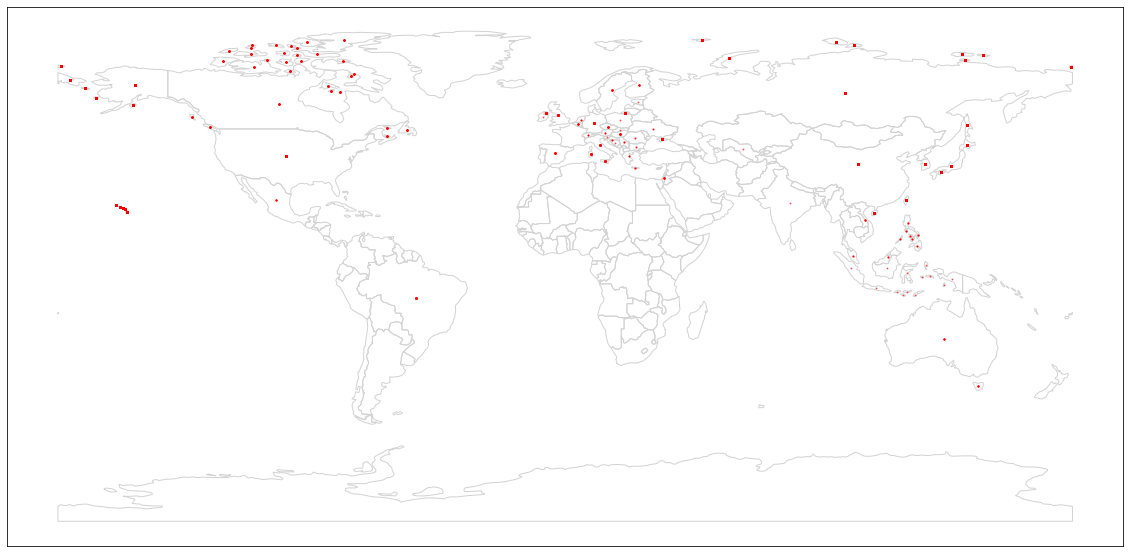

In [21]:
# MAP with centroids only 

plt.figure(figsize=(20,20))
world.plot(ax=plt.gca(), facecolor='none', edgecolor='lightgray')

plt.scatter(nodes_df_['center x'], nodes_df_['center y'], s=1, c='r', alpha=0.5)

#nx.draw_networkx_nodes(G_2013, positions_2013, node_size=10, node_color='k', alpha=0.1)

# plt.gca().add_collection(lc)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.show()

# 2013

/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_1559/634822955.py:36: RuntimeWarning: invalid value encountered in divide
  m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])


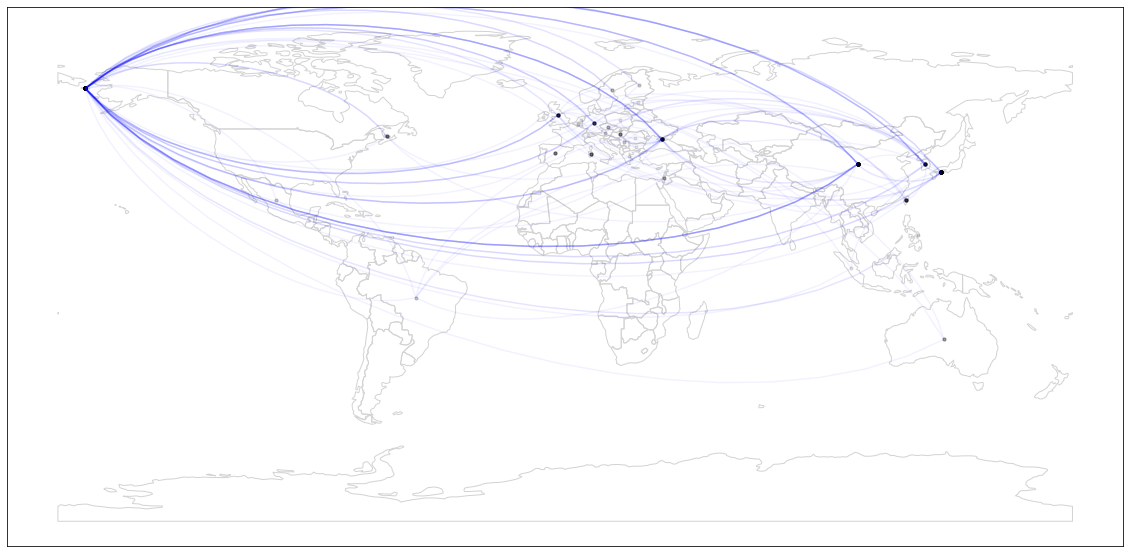

In [22]:
# Map with Network 

curves = curved_edges(G_2013_filtered, positions_2013)
lc = LineCollection(curves, color='blue', alpha=0.05)

plt.figure(figsize=(20,20))
world.plot(ax=plt.gca(), facecolor='none', edgecolor='lightgray')
#plt.scatter(nodes_df_['center x'], nodes_df_['center y'], s=1, c='r', alpha=0.5)

nx.draw_networkx_nodes(G_2013_filtered, positions_2013, node_size=10, node_color='k', alpha=0.1)

plt.gca().add_collection(lc)

plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.show()

# 2023

In [23]:
positions_2023 = {}
counter = 0 
for k, v in pos.items():
    if isinstance(v, tuple) and math.isnan(v[0]) and math.isnan(v[1]):
        positions_2023[k] = (0,0)
        counter =+1 
    else:
        positions_2023[k] = v

print("Found ", counter, " nodes with no position")      

# make sure all nodes have a position
G_2023_filtered = G_2023.copy()
for node in G_2023.nodes():
    if node not in positions_2023:
        G_2023_filtered.remove_node(node)
print("Found ", len(G_2023.nodes()) - len(positions_2023), " nodes with no position")


#positions_2023 = nx.spring_layout(G_2023, iterations =10) #forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

Found  0  nodes with no position
Found  -431  nodes with no position


/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_1559/634822955.py:36: RuntimeWarning: invalid value encountered in divide
  m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])


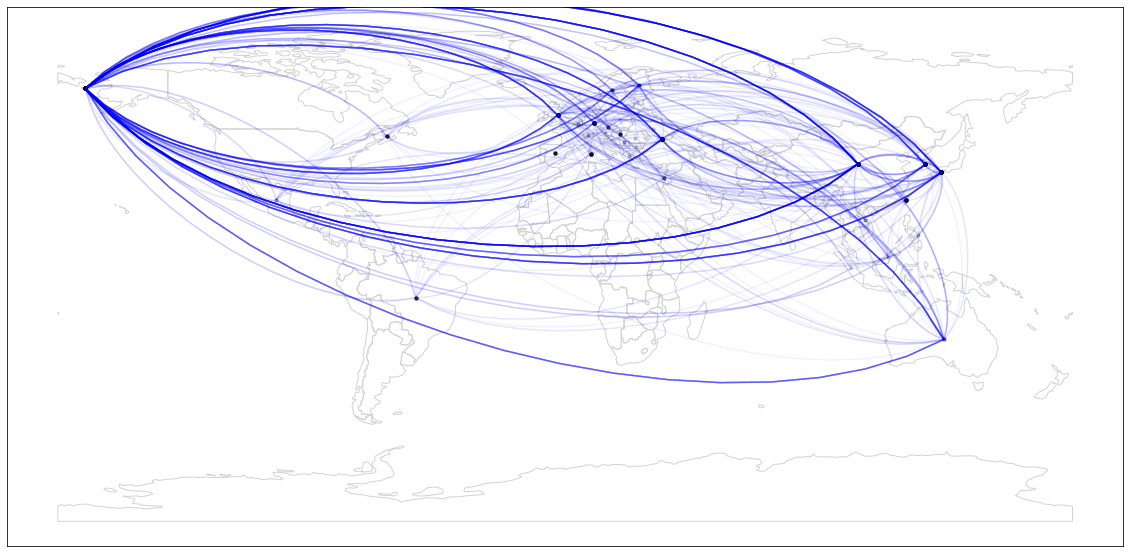

In [24]:
# Map with Network 

curves = curved_edges(G_2023_filtered, positions_2023)
lc = LineCollection(curves, color='blue', alpha=0.05)

plt.figure(figsize=(20,20))
world.plot(ax=plt.gca(), facecolor='none', edgecolor='lightgray')
#plt.scatter(nodes_df_['center x'], nodes_df_['center y'], s=1, c='r', alpha=0.5)

nx.draw_networkx_nodes(G_2023_filtered, positions_2023, node_size=10, node_color='k', alpha=0.1)

plt.gca().add_collection(lc)

plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.show()

In [25]:
#from x and y to lat and long

import pyproj


nodes_geo = nodes_df_.copy()

nodes_geo

,ascii_id_company,name,geometry,iso_a2,name_internat,name_native,postcode,city,city_native,country,...,operating_revenue_turnover,number_of_employees,revenue_per_employee,pop_est,continent,iso_a3,gdp_md_est,centroid,center x,center y
0,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((109.47521 18.19770, 108.65521 18.507...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (109.70379696381478 19.218657635561797),109.703797,19.218658
1,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((80.25999 42.35000, 80.18015 42.92007...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (103.86536125253218 36.60943037956515),103.865361,36.609430
2,+/9MLVq3VTixfe87LXPeeA==,Spain,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,...,51788833.0,184.0,281461.048913,4.895816e+07,Europe,ESP,1690000.0,POINT (-3.6170206023873743 40.348656106226734),-3.617021,40.348656
3,+0MnLjmcWAWGCbG24We7Yw==,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,...,128040853.0,360.0,355669.036111,8.059402e+07,Europe,DEU,3979000.0,POINT (10.288485092742851 51.13372269040778),10.288485,51.133723
4,+1zmH6cnV8mWu/xN4Abihw==,United States of America,"POLYGON ((-122.84000 49.00000, -120.00000 49.0...",US,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,...,3800000.0,100.0,38000.000000,3.266258e+08,North America,USA,18560000.0,POINT (-99.06024062802132 39.50155412599301),-99.060241,39.501554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9437,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-159.36569 22.21494, -159.34512 21.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-159.53597735703593 22.07776133599779),-159.535977,22.077761
9438,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-166.46779 60.38417, -165.67443 60.2...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-166.36502715850503 60.09691413066327),-166.365027,60.096914
9439,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-153.22873 57.96897, -152.56479 57.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-153.50496087659903 57.40668081569972),-153.504961,57.406681
9440,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-140.98599 69.71200, -140.98600 69.7...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-152.72115706788622 64.43561489842035),-152.721157,64.435615


In [26]:
# geocentrc to geodesic 

# Define the projection
geocentric = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
geographic = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

# Convert the coordinates
nodes_geo['longitude'], nodes_geo['latitude'], _ = pyproj.transform(geocentric, geographic, nodes_geo['center x'].values, nodes_geo['center y'].values, np.zeros(len(nodes_geo)))


/var/folders/ln/rnln21vd6jn23nm9wwr0jgs00000gn/T/ipykernel_1559/2782534519.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  nodes_geo['longitude'], nodes_geo['latitude'], _ = pyproj.transform(geocentric, geographic, nodes_geo['center x'].values, nodes_geo['center y'].values, np.zeros(len(nodes_geo)))


In [27]:
nodes_geo_longlat = nodes_geo.drop(['center x', 'center y'], axis=1)

In [28]:
nodes_geo_longlat.to_csv('nodes_geo_longlat.csv', header = True, index = False)

In [29]:
nodes_geo_longlat

,ascii_id_company,name,geometry,iso_a2,name_internat,name_native,postcode,city,city_native,country,...,operating_revenue_turnover,number_of_employees,revenue_per_employee,pop_est,continent,iso_a3,gdp_md_est,centroid,longitude,latitude
0,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((109.47521 18.19770, 108.65521 18.507...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (109.70379696381478 19.218657635561797),9.936630,90.0
1,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((80.25999 42.35000, 80.18015 42.92007...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (103.86536125253218 36.60943037956515),19.416028,90.0
2,+/9MLVq3VTixfe87LXPeeA==,Spain,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,...,51788833.0,184.0,281461.048913,4.895816e+07,Europe,ESP,1690000.0,POINT (-3.6170206023873743 40.348656106226734),95.122539,90.0
3,+0MnLjmcWAWGCbG24We7Yw==,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,...,128040853.0,360.0,355669.036111,8.059402e+07,Europe,DEU,3979000.0,POINT (10.288485092742851 51.13372269040778),78.623563,90.0
4,+1zmH6cnV8mWu/xN4Abihw==,United States of America,"POLYGON ((-122.84000 49.00000, -120.00000 49.0...",US,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,...,3800000.0,100.0,38000.000000,3.266258e+08,North America,USA,18560000.0,POINT (-99.06024062802132 39.50155412599301),158.259718,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9437,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-159.36569 22.21494, -159.34512 21.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-159.53597735703593 22.07776133599779),172.121031,90.0
9438,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-166.46779 60.38417, -165.67443 60.2...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-166.36502715850503 60.09691413066327),160.138493,90.0
9439,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-153.22873 57.96897, -152.56479 57.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-153.50496087659903 57.40668081569972),159.495570,90.0
9440,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-140.98599 69.71200, -140.98600 69.7...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-152.72115706788622 64.43561489842035),157.124304,90.0


In [42]:
nodes_geo_longlat

,ascii_id_company,name,geometry,iso_a2,name_internat,name_native,postcode,city,city_native,country,...,operating_revenue_turnover,number_of_employees,revenue_per_employee,pop_est,continent,iso_a3,gdp_md_est,centroid,longitude,latitude
0,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((109.47521 18.19770, 108.65521 18.507...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (109.70379696381478 19.218657635561797),9.936630,90.0
1,+/7B81WwUmW1o3jUMStX5w==,China,"POLYGON ((80.25999 42.35000, 80.18015 42.92007...",CN,"Xiamen qiangli jucai display technology co., ltd.",厦门强力巨彩显示技术有限公司,361000,Xiamen,厦门市,China,...,298703260.0,360.0,829731.277778,1.379303e+09,Asia,CHN,21140000.0,POINT (103.86536125253218 36.60943037956515),19.416028,90.0
2,+/9MLVq3VTixfe87LXPeeA==,Spain,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES,P4Q Electronics Sociedad Limitada,P4Q Electronics Sociedad Limitada,48810,Alonsotegi,Alonsotegi,Spain,...,51788833.0,184.0,281461.048913,4.895816e+07,Europe,ESP,1690000.0,POINT (-3.6170206023873743 40.348656106226734),95.122539,90.0
3,+0MnLjmcWAWGCbG24We7Yw==,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",DE,Multitest elektronische Systeme GmbH,Multitest elektronische Systeme GmbH,83026,Rosenheim,Rosenheim,Germany,...,128040853.0,360.0,355669.036111,8.059402e+07,Europe,DEU,3979000.0,POINT (10.288485092742851 51.13372269040778),78.623563,90.0
4,+1zmH6cnV8mWu/xN4Abihw==,United States of America,"POLYGON ((-122.84000 49.00000, -120.00000 49.0...",US,Quartz International Corp,Quartz International Corp,87113-2104,Albuquerque,Albuquerque,United States of America,...,3800000.0,100.0,38000.000000,3.266258e+08,North America,USA,18560000.0,POINT (-99.06024062802132 39.50155412599301),158.259718,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9437,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-159.36569 22.21494, -159.34512 21.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-159.53597735703593 22.07776133599779),172.121031,90.0
9438,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-166.46779 60.38417, -165.67443 60.2...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-166.36502715850503 60.09691413066327),160.138493,90.0
9439,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-153.22873 57.96897, -152.56479 57.9...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-153.50496087659903 57.40668081569972),159.495570,90.0
9440,zzY/xgpdXhm3ORHIkr25UA==,United States of America,"POLYGON ((-140.98599 69.71200, -140.98600 69.7...",US,Aquantia Corp.,Aquantia Corp.,95134,San Jose,San Jose,United States of America,...,120784000.0,310.0,389625.806452,3.266258e+08,North America,USA,18560000.0,POINT (-152.72115706788622 64.43561489842035),157.124304,90.0


In [30]:
nodes_geo_longlat_ = pd.DataFrame(index=nodes_geo_longlat.index)
nodes_geo_longlat_['ascii_id_company'] = nodes_geo_longlat["ascii_id_company"]
nodes_geo_longlat_['iso_a2'] = nodes_geo_longlat["iso_a2"]
nodes_geo_longlat_['longitude'] = nodes_geo_longlat["longitude"]
nodes_geo_longlat_['latitude'] = nodes_geo_longlat["latitude"]
nodes_geo_longlat_

,ascii_id_company,iso_a2,longitude,latitude
0,+/7B81WwUmW1o3jUMStX5w==,CN,9.936630,90.0
1,+/7B81WwUmW1o3jUMStX5w==,CN,19.416028,90.0
2,+/9MLVq3VTixfe87LXPeeA==,ES,95.122539,90.0
3,+0MnLjmcWAWGCbG24We7Yw==,DE,78.623563,90.0
4,+1zmH6cnV8mWu/xN4Abihw==,US,158.259718,90.0
...,...,...,...,...
9437,zzY/xgpdXhm3ORHIkr25UA==,US,172.121031,90.0
9438,zzY/xgpdXhm3ORHIkr25UA==,US,160.138493,90.0
9439,zzY/xgpdXhm3ORHIkr25UA==,US,159.495570,90.0
9440,zzY/xgpdXhm3ORHIkr25UA==,US,157.124304,90.0


# CODE SNIPPETS

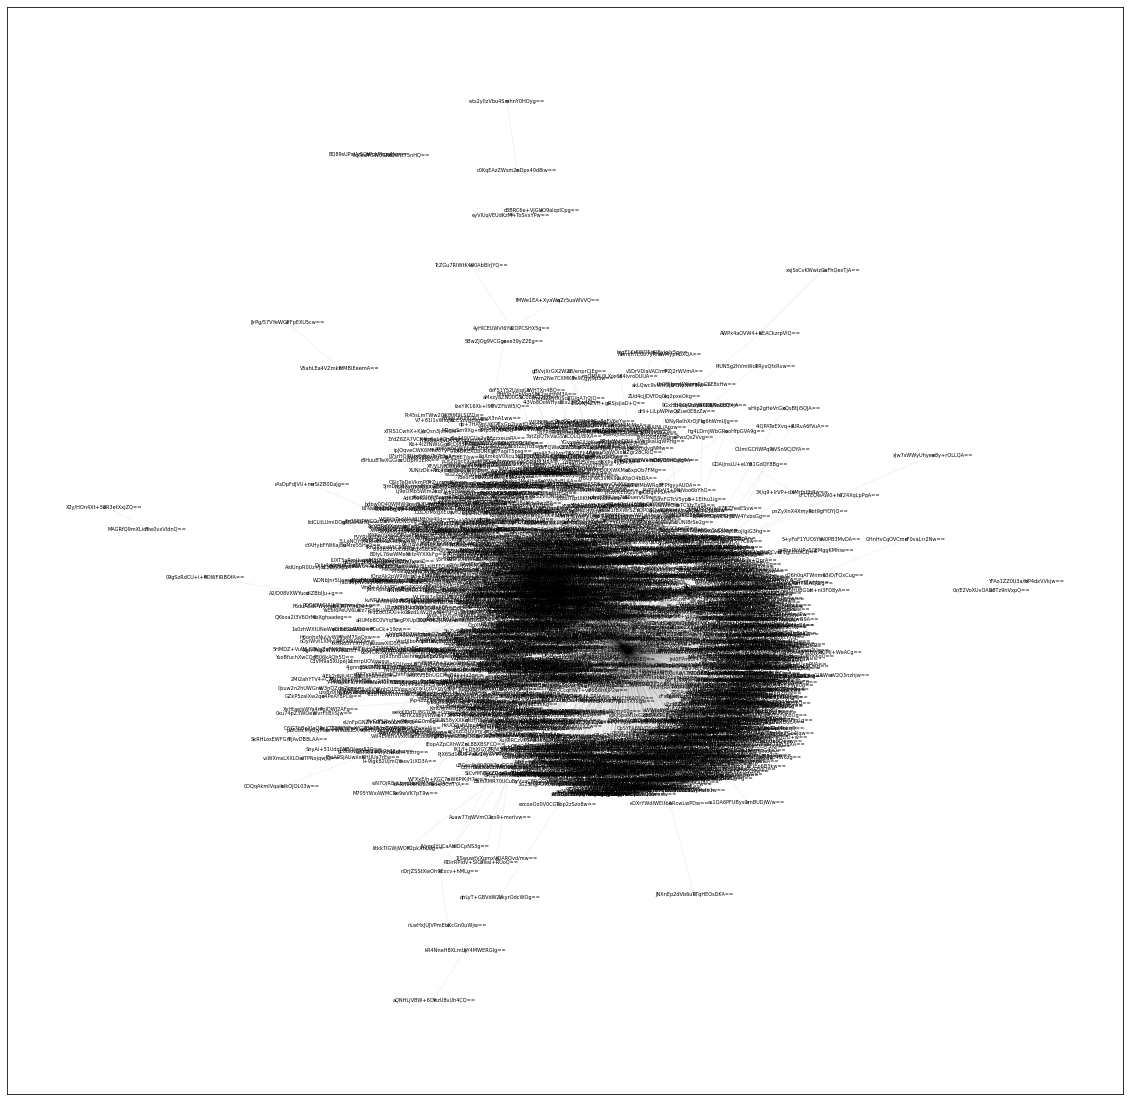

In [165]:
positions_2013_spring = nx.spring_layout(G_2023, iterations =10) #forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

#plot with networkx 
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G_2023, positions_2013_spring, node_size=5, node_color='k', alpha=0.4)
nx.draw_networkx_edges(G_2023, positions_2013_spring, alpha=0.05)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)

plt.show()


In [1]:
from cartoGRAPHs import *

### centrality based layout

In [13]:
# get network cetnralities 
d_degree_2013 = nx.degree_centrality(G_2013)
d_close_2013 = nx.closeness_centrality(G_2013)
d_between_2013 = nx.betweenness_centrality(G_2013)
d_eigen_2013 = nx.eigenvector_centrality(G_2013)

Matrix = pd.DataFrame([d_degree_2013, d_close_2013, d_between_2013, d_eigen_2013]).T
Matrix

,0,1,2,3
+CY58D3RXbaPGtbNczkwkA==,0.065719,0.425444,0.088438,0.096754
0yd99stpXMW98ycgIDk9Mg==,0.030195,0.400396,0.016085,0.078205
1SPLf5bUUHGLwuTcWsh00Q==,0.014210,0.298325,0.007839,0.013145
1fqkJPEgWNSBSjshlZZ4Wg==,0.012433,0.295135,0.013264,0.009117
3ZjoxOm+X8KGpWJD66yXWg==,0.523979,0.569496,0.701058,0.689702
...,...,...,...,...
NPI5u7ZxULmVIT/cg8R5gQ==,0.001776,0.271880,0.000000,0.003388
WgRbG5RqWL2juqgk0+P03g==,0.001776,0.271880,0.000000,0.003388
cUcvHVnSWPSc+cvpmNP5IQ==,0.001776,0.271880,0.000000,0.003388
dy42m4aTVpqLpCFkUR4SzA==,0.001776,0.271880,0.000000,0.003388


In [39]:
# %%time 

n_n = 10 #12 #20  
spr = 1.0 #1.0 #0.9  
md = 0.1 #0.3 #0.1 #0.25 

umap_sphere = embed_umap_sphere(Matrix, n_n, spr, md)


In [49]:
##########################################################
#
# RADIUS / SPHERE LAYERS determined with degree centrality
#
##########################################################

# normalize degree 
max_deg = max(d_degree_2013.values())

d_degree_norminverse = {}
for k,v in d_degree_2013.items():
    normed_v = v/max_deg
    d_degree_norminverse[k] = np.log(v)
    
# bin degree 
d_degree_binned = {}
for k, g in itertools.groupby(sorted(d_degree_norminverse.values()), lambda x: x // 0.001):
    d_degree_binned[k]=list(g)
    
print('Number of bins:',len(d_degree_binned))

# modify dictionary to get node:binvalue 
d_degree_mod = {}
for node,v in d_degree_norminverse.items():
    for bn,val in d_degree_binned.items():
        for elem in val:
            if v == elem:
                d_degree_mod[node]=bn

posG3D = get_posG_sphere_norm(G_2013, Matrix, umap_sphere, d_degree_2013)

df_posG3D = pd.DataFrame(posG3D).T

Number of bins: 20


In [52]:
%%time 

n_n = 10 #6 #12 #20  
spr = 1.0 #1.0 #0.9  
md = 0.9 #0.3 #0.1 #0.25 

posG_umap2D = layout_portrait_umap(G_2013,
                                   df_posG3D,
                                   2,
                                   n_neighbors=n_n, 
                                   spread=spr, 
                                   min_dist=md, 
                                   metric='euclidean'
                                  )
posG = posG_umap2D

CPU times: user 2.55 s, sys: 138 ms, total: 2.69 s
Wall time: 2.59 s


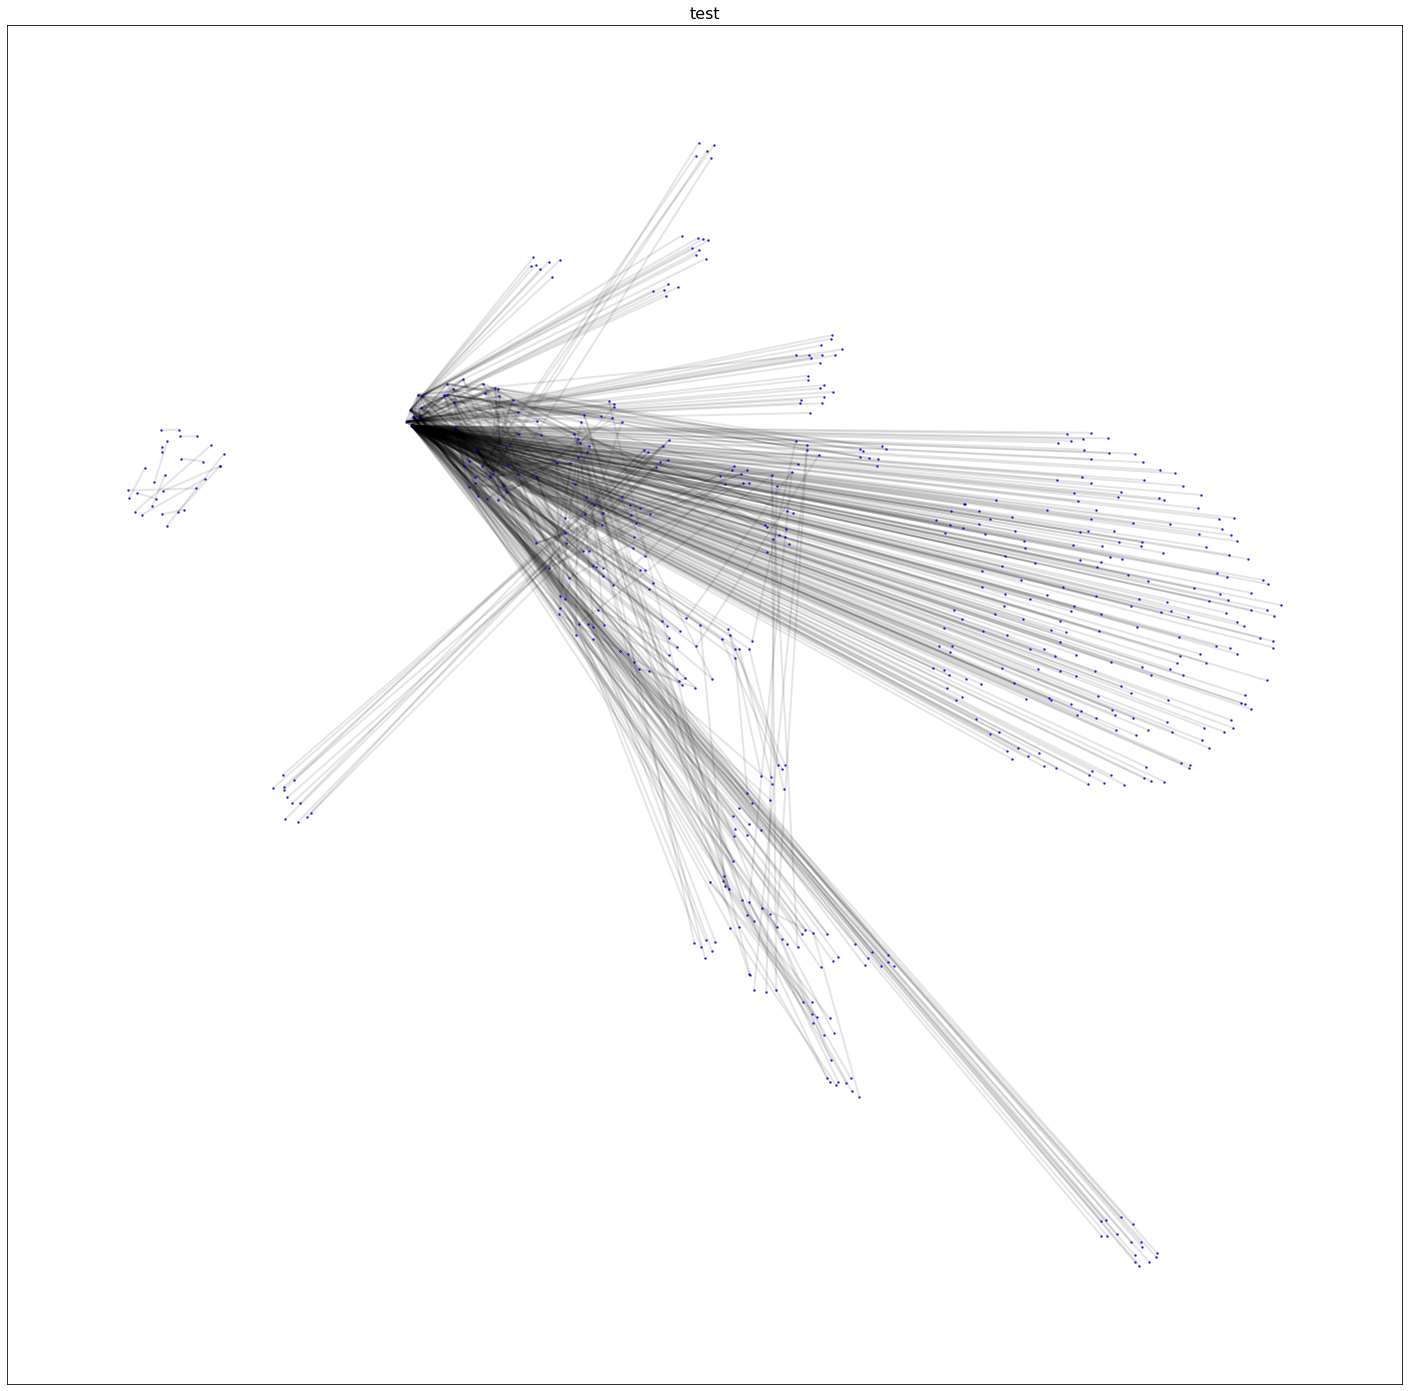

In [53]:
path = ''
fname = 'test'

plt.figure(figsize=(25,25))
plt.title(fname, size=16)

nx.draw_networkx_nodes(G_2013, 
                       posG,
                       edgecolors = 'k',
                       linewidths = 0.1, 
                       node_color = 'blue', 
                       node_size = 5, 
                       alpha = 0.9)

nx.draw_networkx_edges(G_2013, posG, width = 2, edge_color = 'k', alpha = 0.1)
#plt.box(False)

#plt.savefig(path+fname+'.png',dpi=300)
plt.show()

In [54]:
posG_2D_global = layout_global_umap(G_2013, 2, n_neighbors=n_n, spread=spr, min_dist=md, metric='cosine')

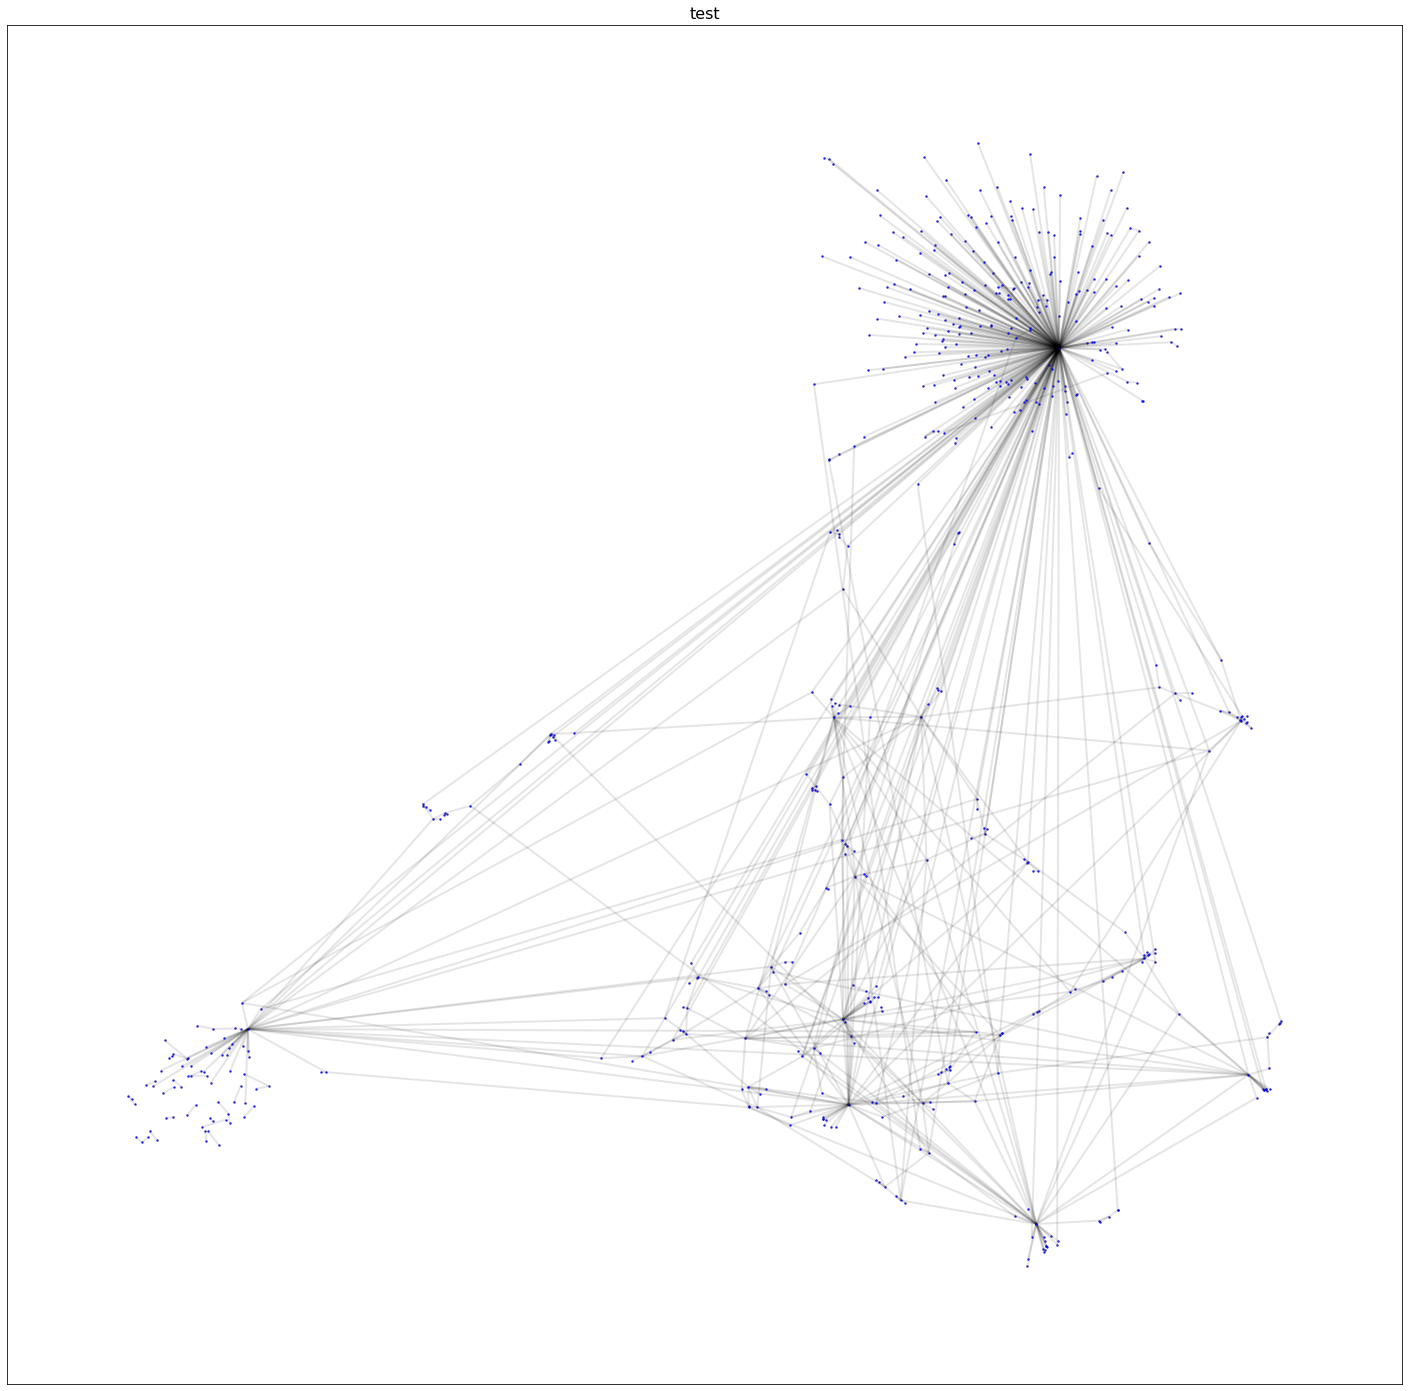

In [36]:
path = ''
fname = 'test'

plt.figure(figsize=(25,25))
plt.title(fname, size=16)

nx.draw_networkx_nodes(G_2013, 
                       posG_2D_global,
                       edgecolors = 'k',
                       linewidths = 0.1, 
                       node_color = 'blue', 
                       node_size = 5, 
                       alpha = 0.9)

nx.draw_networkx_edges(G_2013, posG_2D_global, width = 2, edge_color = 'k', alpha = 0.1)
#plt.box(False)

#plt.savefig(path+fname+'.png',dpi=300)
plt.show()

## Example Network
Resource : 
DATA : https://snap.stanford.edu/data/egonets-Facebook.html

In [6]:
!pip install networkx==2.7


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [7]:
# Load the graph edges and compute the node positions using ForceAtlas2
G = nx.read_edgelist(inputpath + 'facebook_combined.txt')

positions = nx.spring_layout(G, iterations =10) #forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

# Produce the curves
curves = curved_edges(G, positions)
lc = LineCollection(curves, color='k', alpha=0.05)

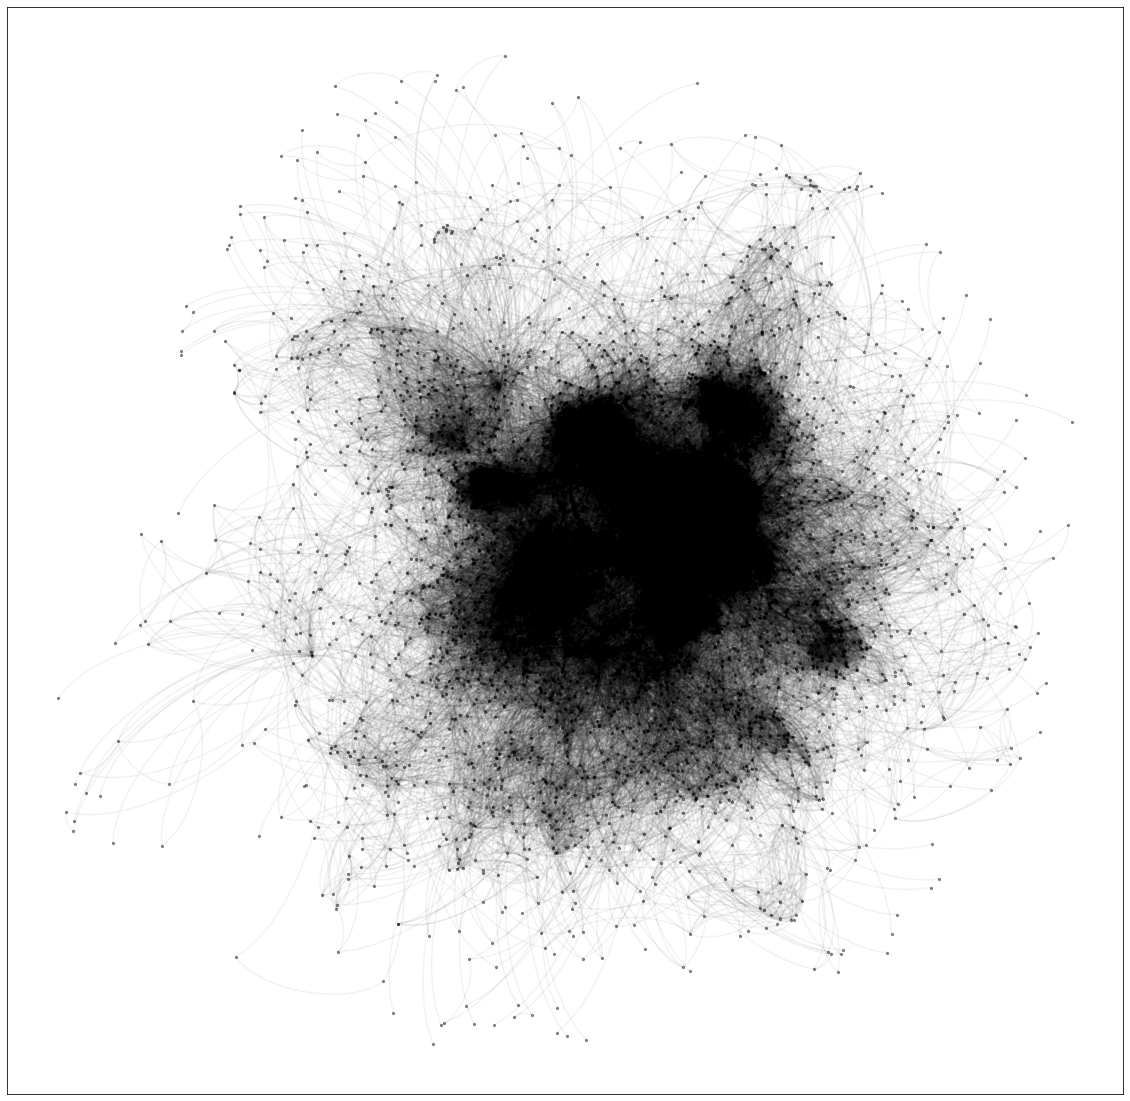

In [8]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, positions, node_size=5, node_color='k', alpha=0.4)
plt.gca().add_collection(lc)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.show()